In [9]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from scipy.integrate import cumulative_trapezoid
from astropy.coordinates import SkyCoord

import sys
sys.path.append('../src')
import plotting, helpers
from importlib import reload

In [2]:
%config InlineBackend.figure_format = 'retina'


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7*fs,
          'legend.title_fontsize': 0.8*fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [43]:
pop_files = ["binaries", "binaries-kickflag-5-ecsn-0", "binaries-kickflag-1-ecsn-2.25",
             "binaries-kickflag-1-ecsn-0"]
pops = [cogsworth.pop.load(f"/mnt/ceph/users/twagg/underworld/{f}", parts=[]) for f in pop_files]

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential20

In [44]:
labels = ["Disberg", "Disberg, No ECSN", "Hobbs", "Hobbs, No ECSN"]
for pop, f in zip(pops, labels):
    pop.label = f

for i, pop in enumerate(pops):
    pop.colour = mpl.colormaps['tab10'].colors[i]
    pop.bpp["row_num"] = np.arange(len(pop.bpp))

In [45]:
reload(helpers)
reload(plotting)

<module 'plotting' from '/mnt/home/twagg/projects/underworld/analysis/../src/plotting.py'>

In [46]:
kinematics = helpers.get_kinematics(pops)

Inner 10 kpc
  Disberg fraction within 0.5 kpc 0.47
  Hobbs fraction within 0.5 kpc 0.44
Full population
  Disberg fraction within 0.5 kpc 0.37
  Hobbs fraction within 0.5 kpc 0.29


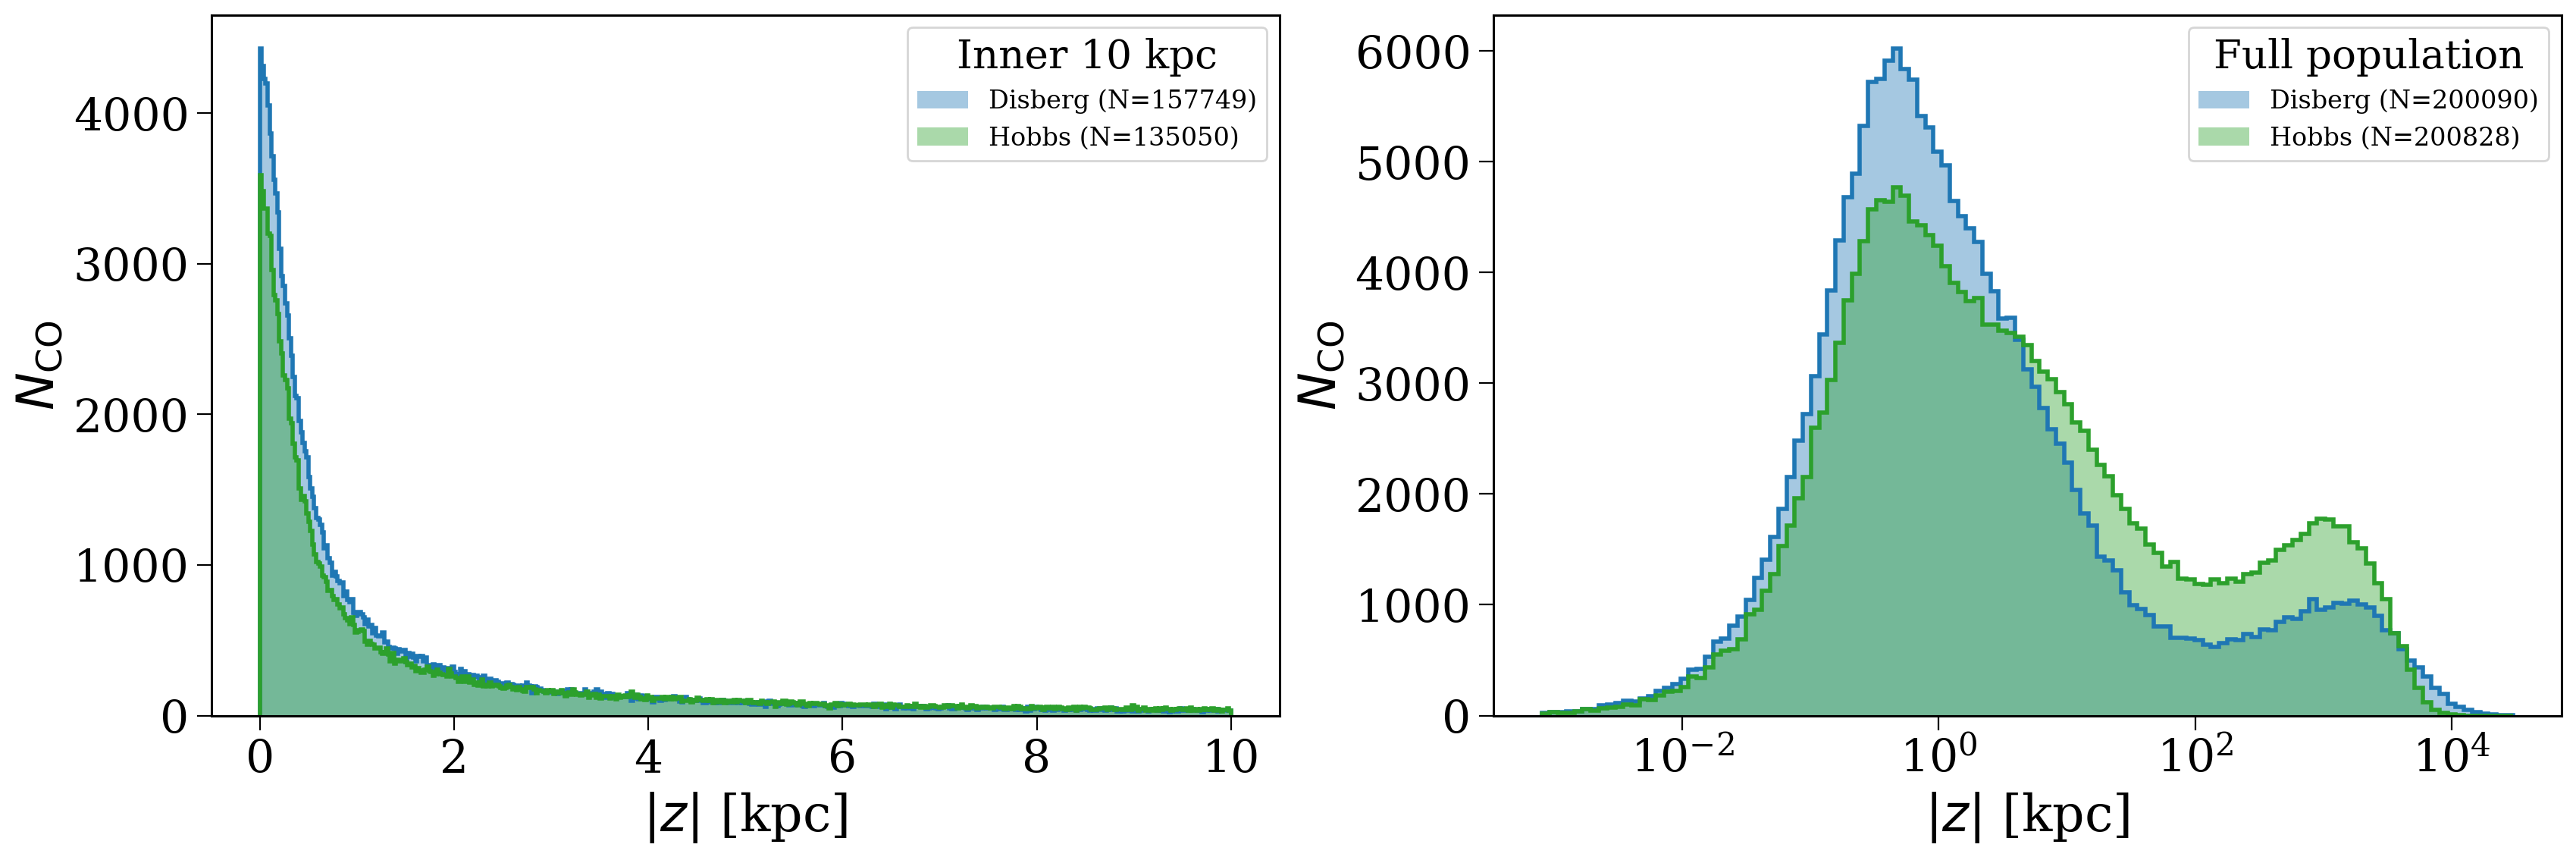

Inner 10 kpc
  Disberg fraction within 0.5 kpc 0.47
  Disberg, No ECSN fraction within 0.5 kpc 0.46
  Hobbs fraction within 0.5 kpc 0.44
  Hobbs, No ECSN fraction within 0.5 kpc 0.43
Full population
  Disberg fraction within 0.5 kpc 0.37
  Disberg, No ECSN fraction within 0.5 kpc 0.36
  Hobbs fraction within 0.5 kpc 0.29
  Hobbs, No ECSN fraction within 0.5 kpc 0.29


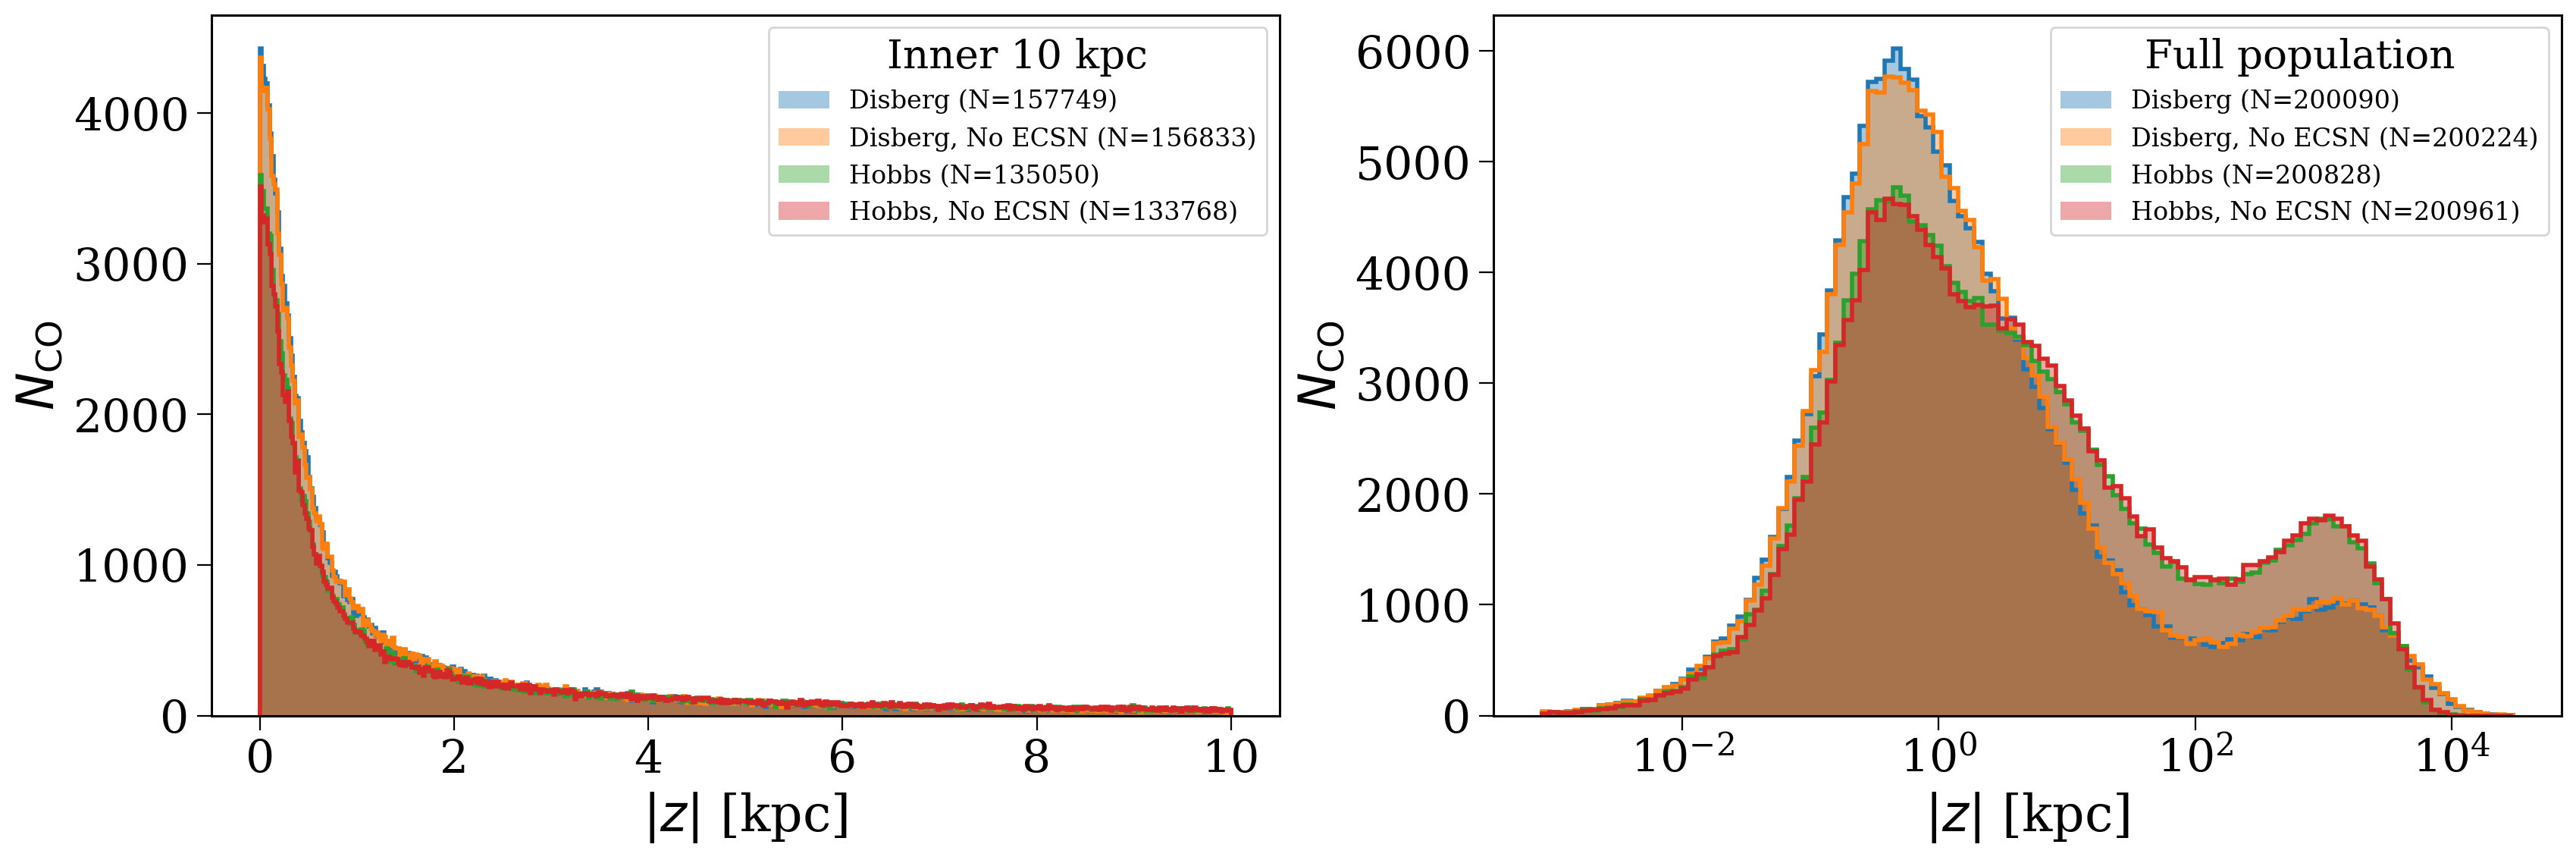

(<Figure size 2000x600 with 2 Axes>,
 array([<Axes: xlabel='$|z|$ [kpc]', ylabel='$N_{\\rm CO}$'>,
        <Axes: xlabel='$|z|$ [kpc]', ylabel='$N_{\\rm CO}$'>], dtype=object))

In [47]:
plotting.absolute_scale_height([pop for pop in pops if "ECSN" not in pop.label], kinematics)
plotting.absolute_scale_height(pops, kinematics)

In [48]:
print("Escaped fractions:")
for pop in pops:
    escaped = kinematics[pop.label]["escaped"]["CO"]
    frac = escaped.sum() / len(escaped)
    print(f'  - {pop.label}:')
    print(f'      - CO = {kinematics[pop.label]["escaped"]["CO"].sum() / len(kinematics[pop.label]["escaped"]["CO"]):1.3f}')
    print(f'      - BH = {kinematics[pop.label]["escaped"]["BH"].sum() / len(kinematics[pop.label]["escaped"]["BH"]):1.3f}')
    print(f'      - NS = {kinematics[pop.label]["escaped"]["NS"].sum() / len(kinematics[pop.label]["escaped"]["NS"]):1.3f}')

Escaped fractions:
  - Disberg:
      - CO = 0.112
      - BH = 0.030
      - NS = 0.143
  - Disberg, No ECSN:
      - CO = 0.114
      - BH = 0.030
      - NS = 0.145
  - Hobbs:
      - CO = 0.168
      - BH = 0.030
      - NS = 0.221
  - Hobbs, No ECSN:
      - CO = 0.172
      - BH = 0.031
      - NS = 0.226


200182
200314
200909
201042


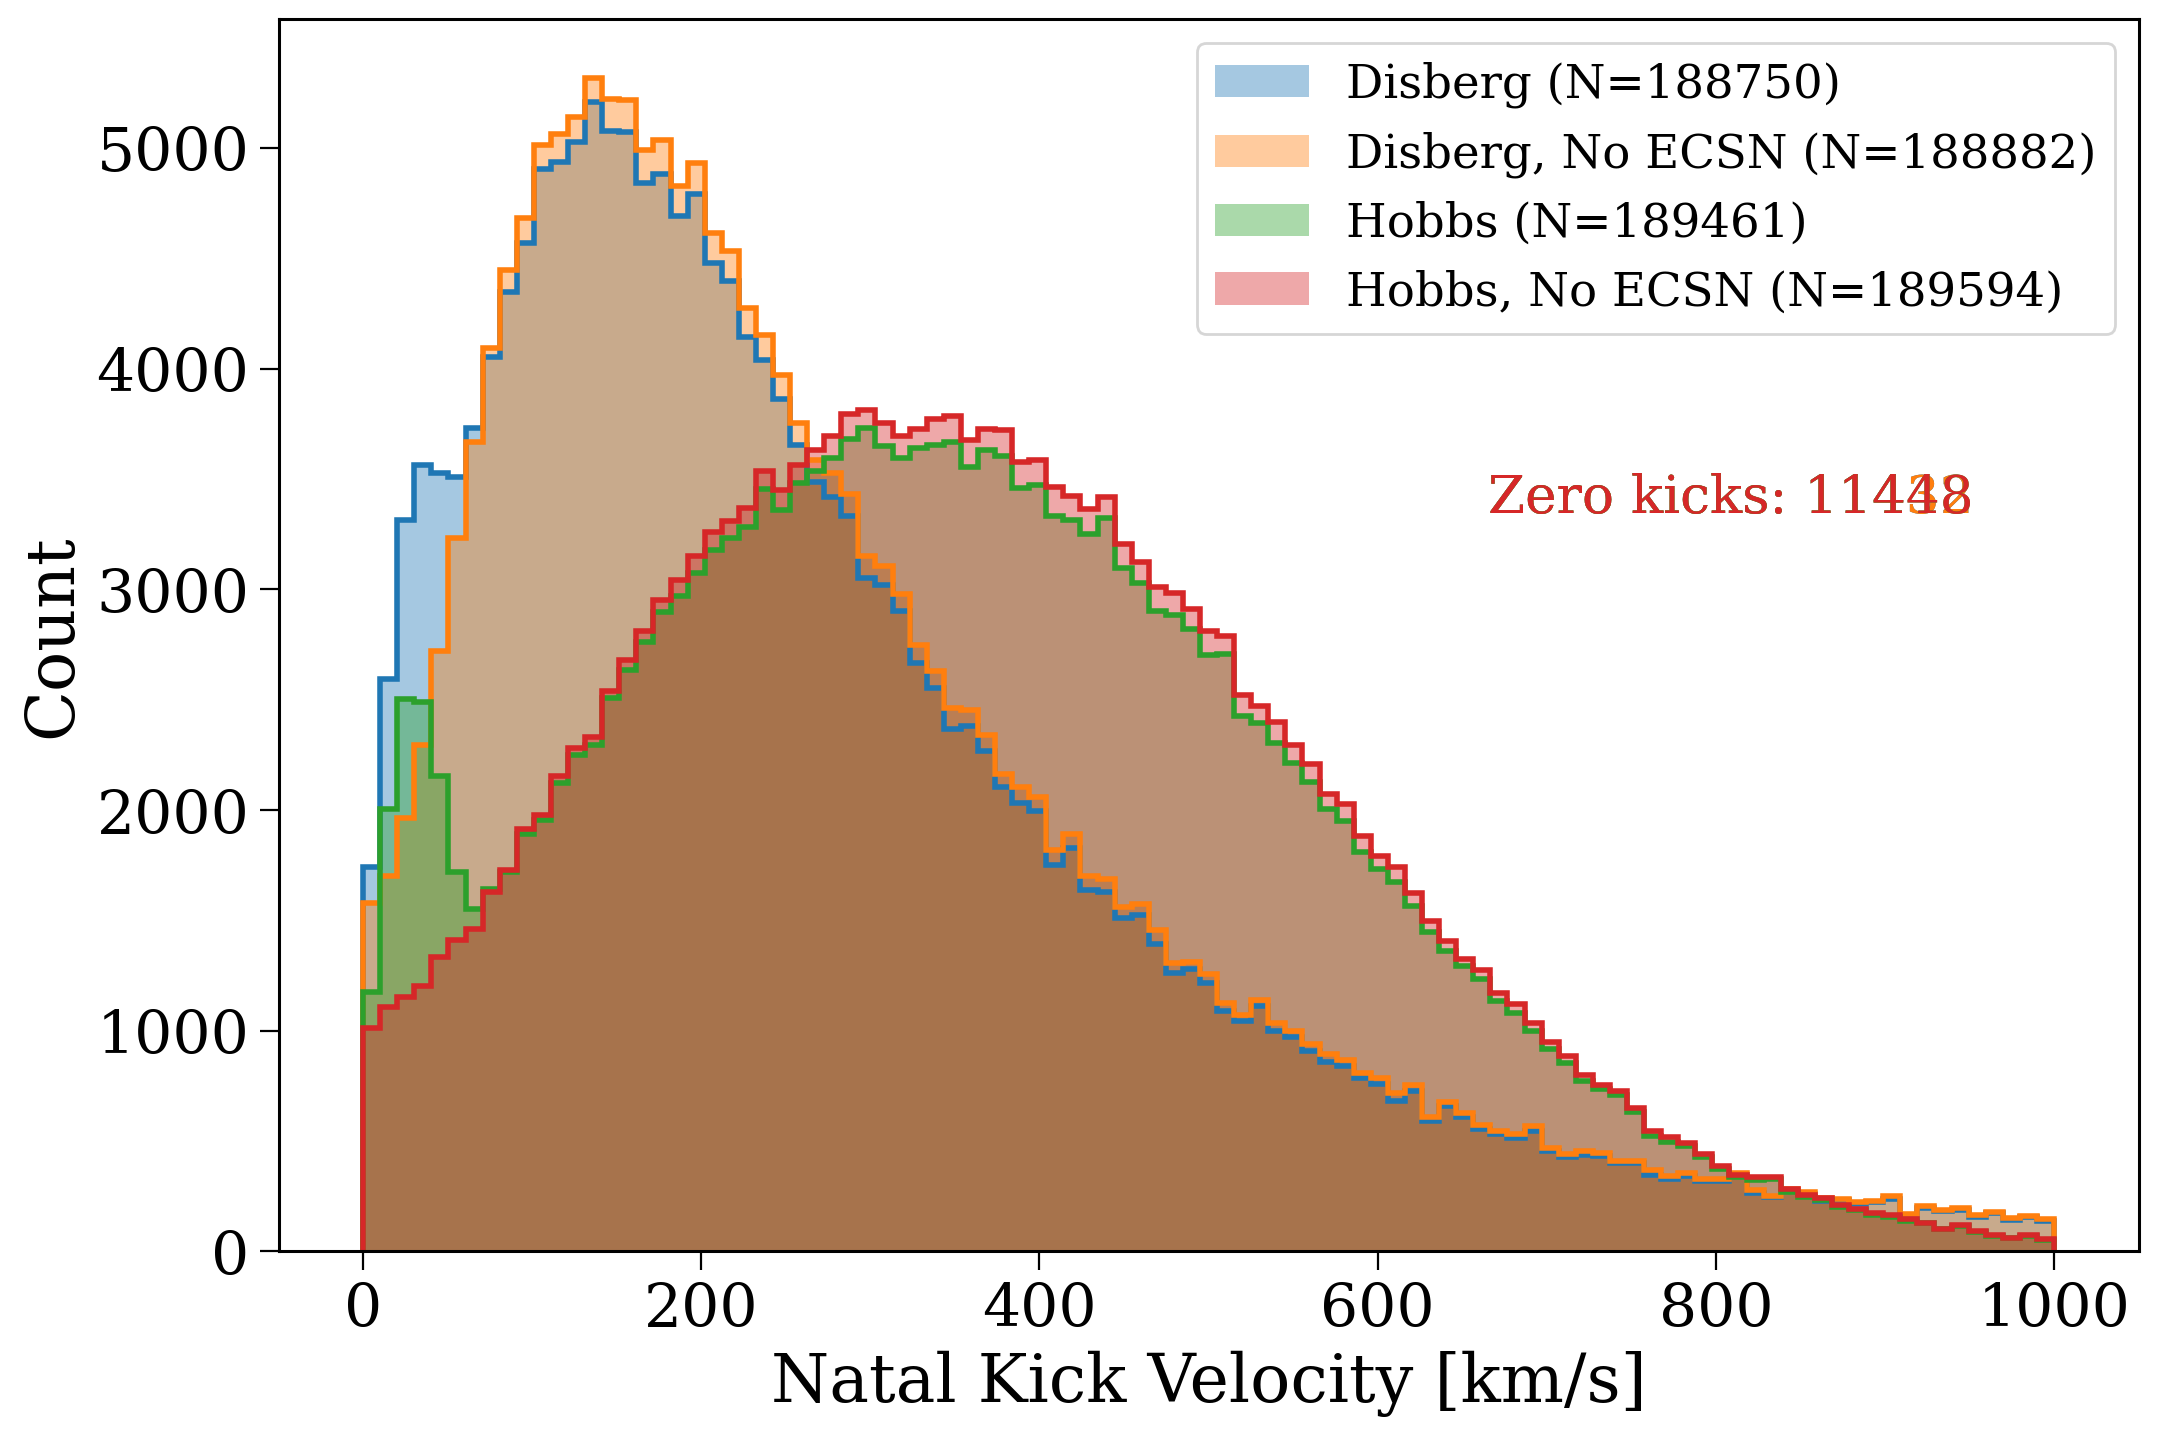

200182
200314
200909
201042


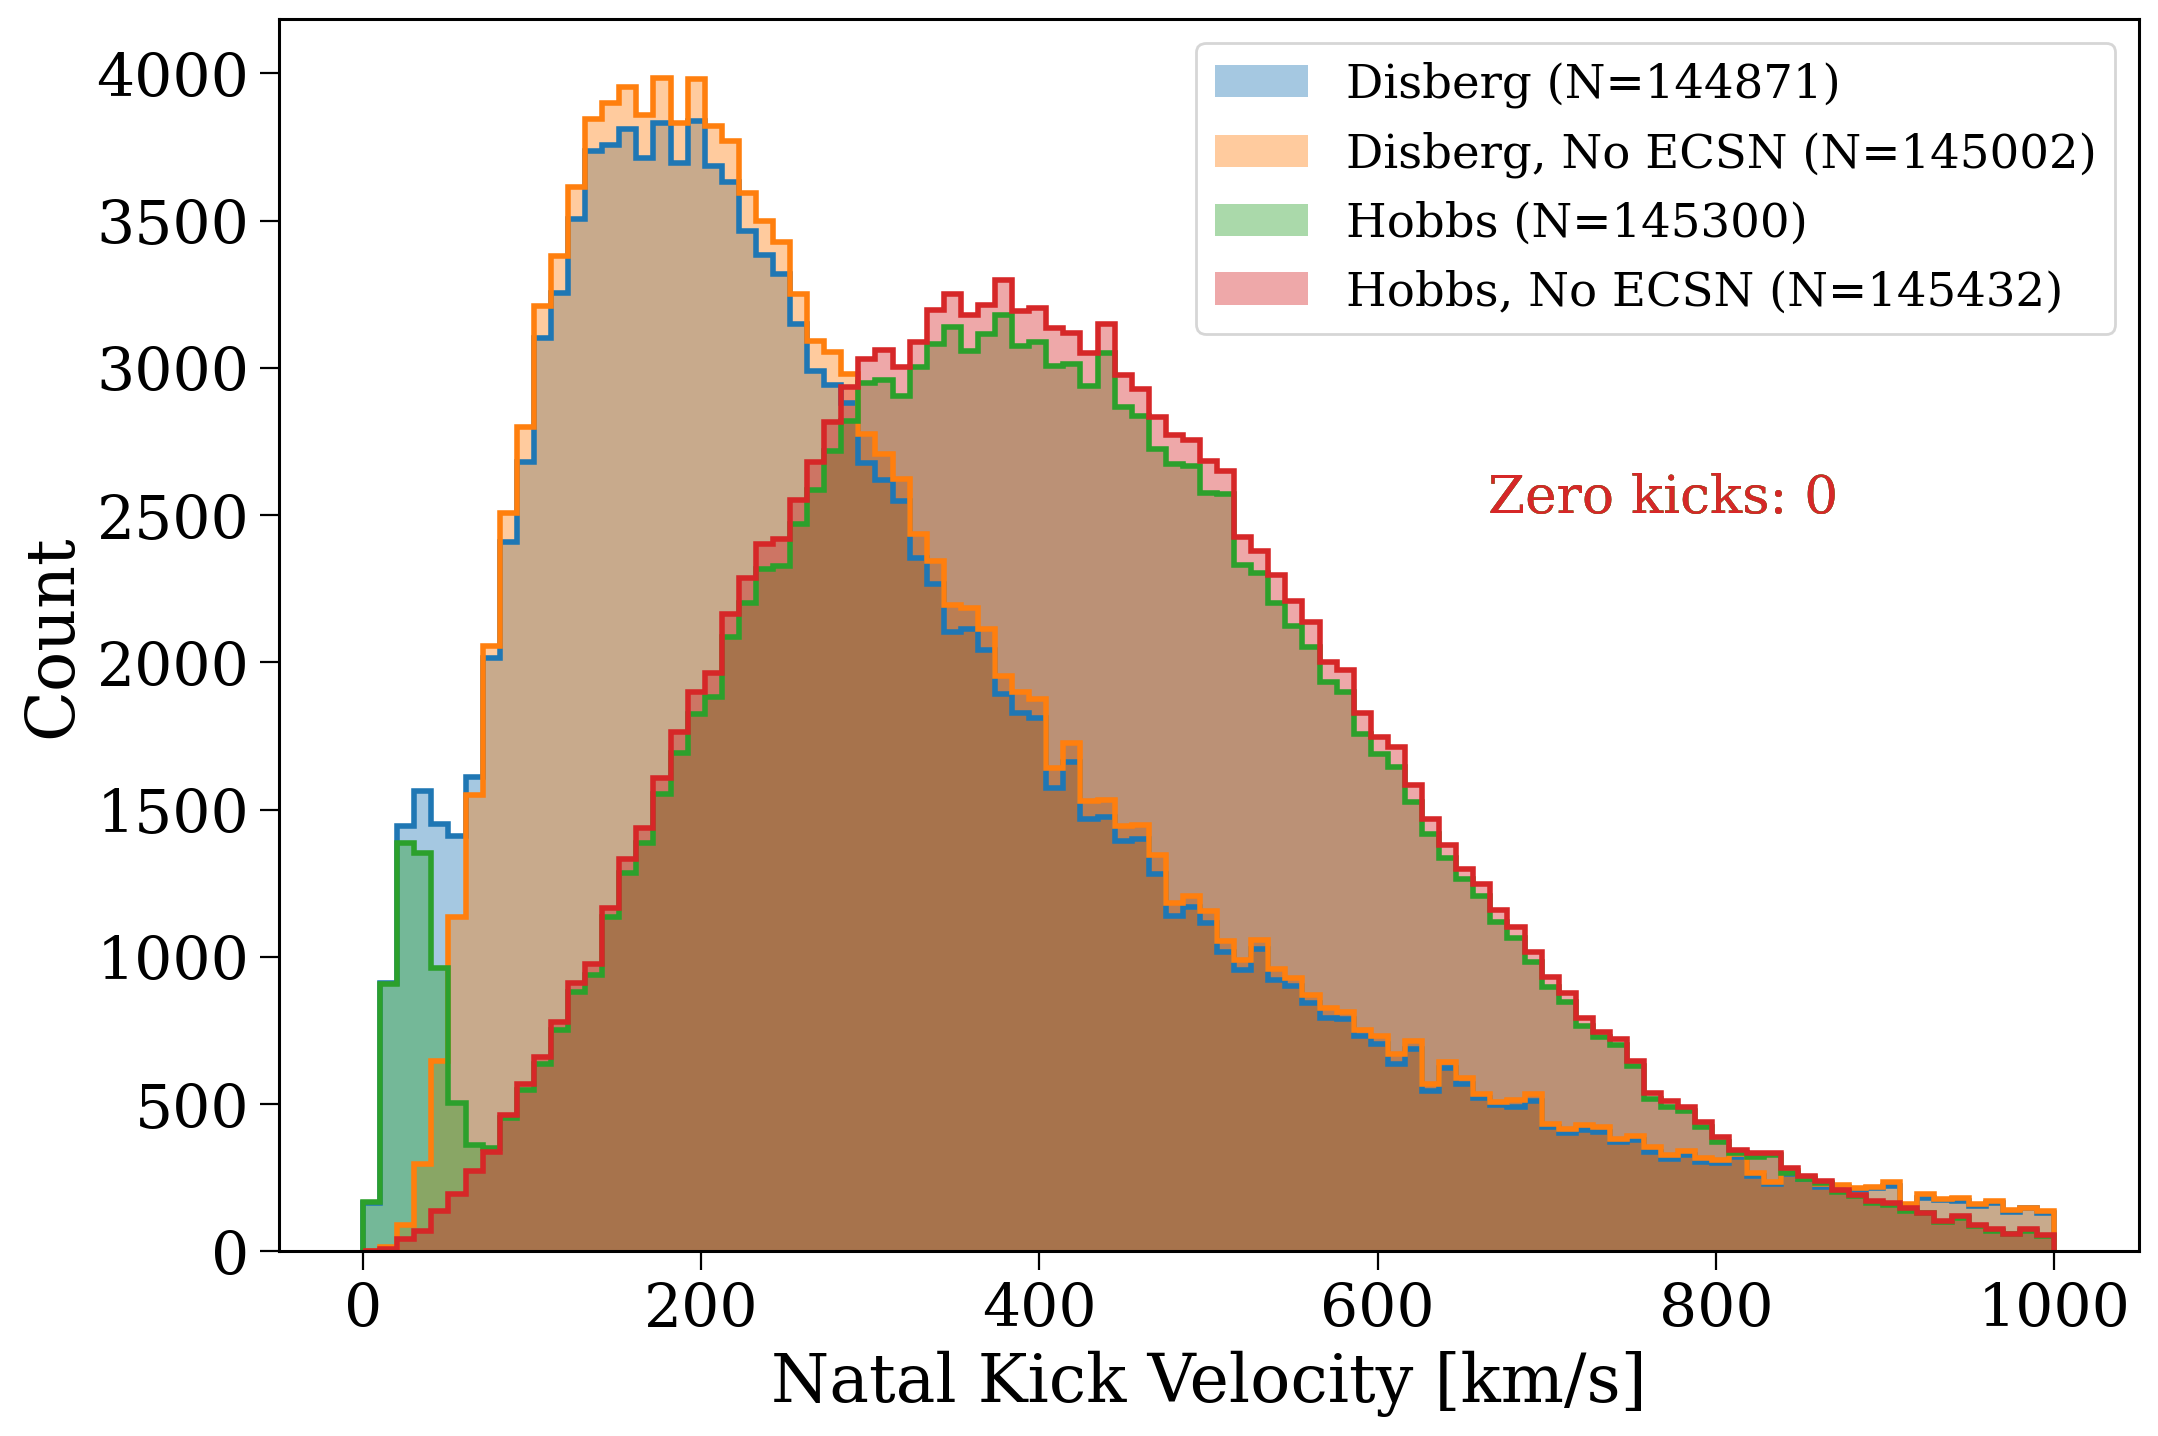

200182
200314
200909
201042


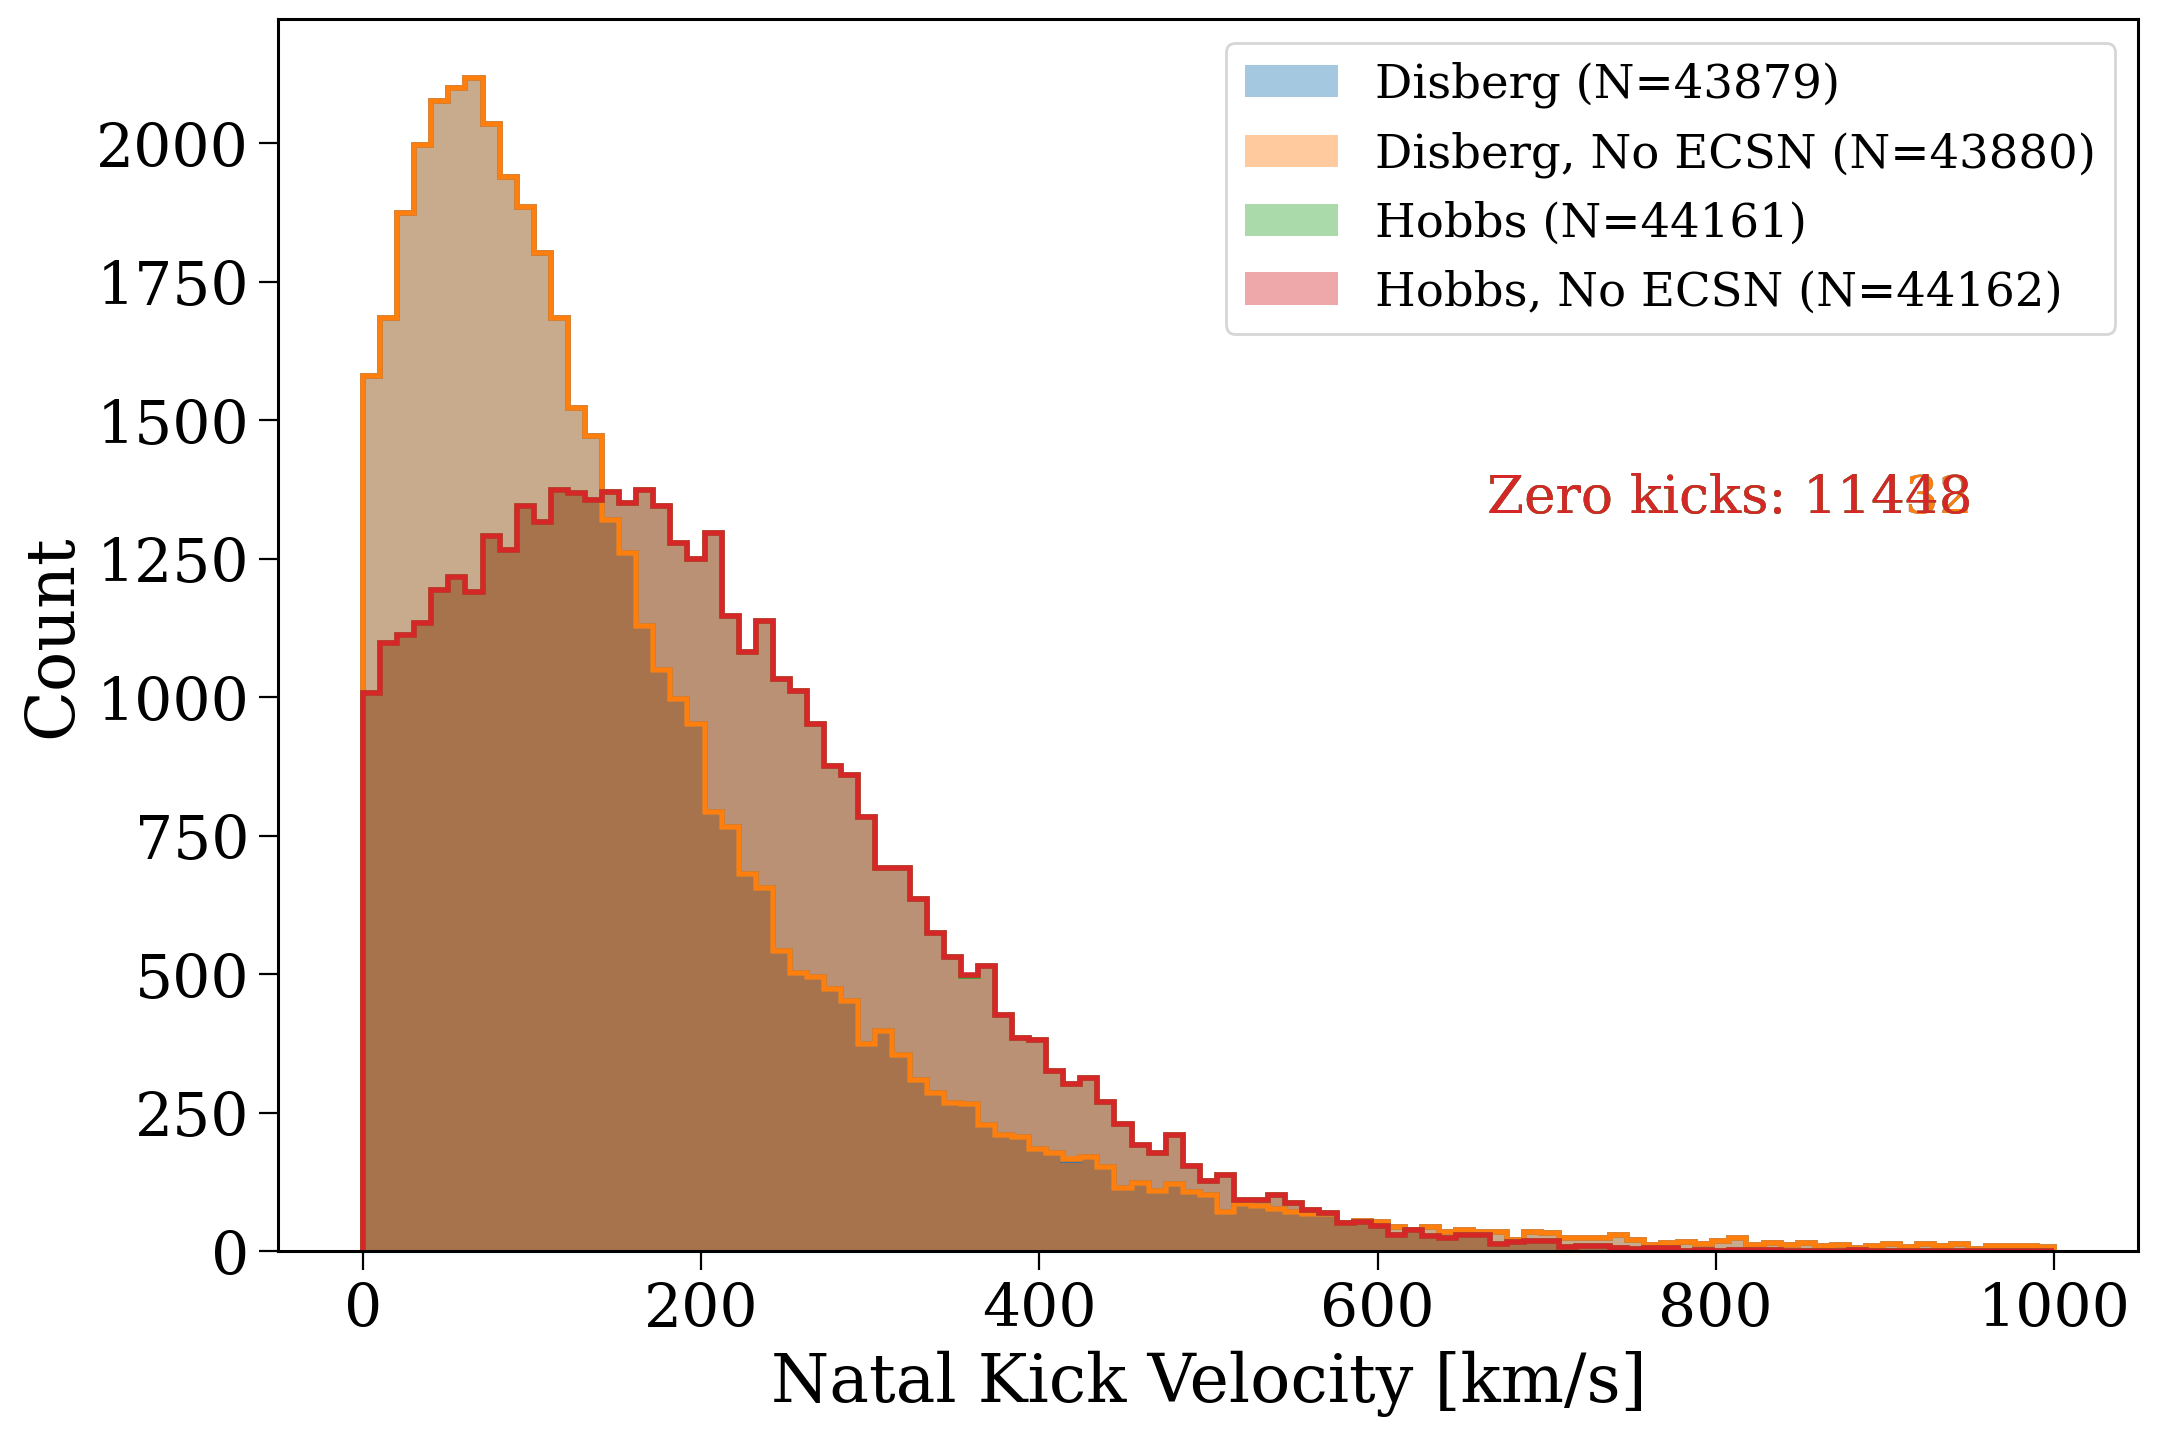

In [49]:
density = False
for co_type_label, co_type in zip(["ALL", "NS", "BH"], [[13, 14], [13], [14]]):

    fig, ax = plt.subplots()

    bins = np.linspace(0, 1000, 100)

    for pop in pops:
        kick_details = pop.kick_info[pop.kick_info["star"] != 0]
        kicks = kick_details["natal_kick"]
        print(len(kicks))

        kick_rows = pop.bpp[pop.bpp["evol_type"].isin([15, 16])]
        after_kick_rows = pop.bpp[pop.bpp["row_num"].isin(kick_rows["row_num"] + 1)]
        kick_co_type = np.where(kick_details["star"] == 1, after_kick_rows["kstar_1"], after_kick_rows["kstar_2"])
        
        kicks = kicks[(np.isin(kick_co_type, co_type))]
        n_zero_kicks = (kicks == 0.0).sum()
        kicks = kicks[(kicks != 0.0)]

        ax.hist(kicks, bins=bins, density=density, histtype='step', lw=2, color=pop.colour)
        ax.hist(kicks, bins=bins, density=density, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(kicks)})")
        
        ax.annotate(
            f"Zero kicks: {n_zero_kicks}",
            xy=(0.65, 0.65 - 0.05 * (0 if pop.label == "Singles" else 1)),
            xycoords='axes fraction',
            color=pop.colour,
            fontsize=0.8*fs,
        )

    ax.set(
        xlabel="Natal Kick Velocity [km/s]",
        ylabel="Count",
    )
    ax.legend()
    plt.show()

In [50]:
reload(helpers)
underworld_binaries = helpers.get_underworld_binaries(pops, verbose=True)

Disberg Underworld Binaries (scale up by 3308x):
  BH-BH:     1041  	3.4e+06 (scaled)
  BH-NS:     37  	1.2e+05 (scaled)
  BH-WD:     167  	5.5e+05 (scaled)
  BH-Star:   2  	6.6e+03 (scaled)

  NS-NS:     2  	6.6e+03 (scaled)
  NS-WD:     121  	4.0e+05 (scaled)
  NS-Star:   15  	5.0e+04 (scaled)

Disberg, No ECSN Underworld Binaries (scale up by 3308x):
  BH-BH:     1041  	3.4e+06 (scaled)
  BH-NS:     35  	1.2e+05 (scaled)
  BH-WD:     167  	5.5e+05 (scaled)
  BH-Star:   2  	6.6e+03 (scaled)

  NS-NS:     2  	6.6e+03 (scaled)
  NS-WD:     112  	3.7e+05 (scaled)
  NS-Star:   15  	5.0e+04 (scaled)

Hobbs Underworld Binaries (scale up by 3308x):
  BH-BH:     931  	3.1e+06 (scaled)
  BH-NS:     11  	3.6e+04 (scaled)
  BH-WD:     116  	3.8e+05 (scaled)
  BH-Star:   3  	9.9e+03 (scaled)

  NS-NS:     3  	9.9e+03 (scaled)
  NS-WD:     49  	1.6e+05 (scaled)
  NS-Star:   10  	3.3e+04 (scaled)

Hobbs, No ECSN Underworld Binaries (scale up by 3308x):
  BH-BH:     931  	3.1e+06 (scaled)
  BH-NS: 